In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, random_split
from old.networks import Model
from old.dropout import *

from data import generate_data
from old.train import train_main_model, train_regular_deup, train_regular_deup_plusplus
from old.utils import inv_sigmoid, evaluate_and_plot, eval_error_regular_deup

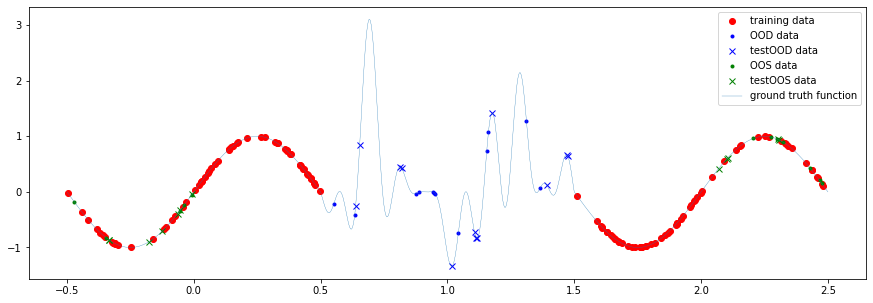

In [5]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 24, 24, seed=7, plot=True, save_plot='figs/motivating.png')

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

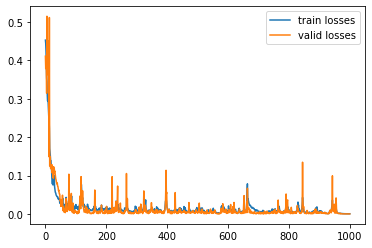

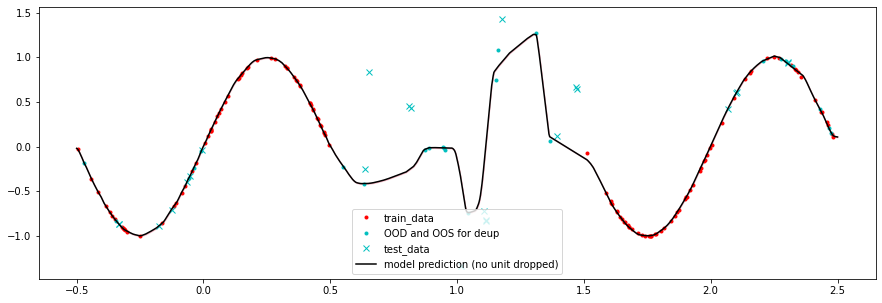

In [37]:
# SANITY CHECK ONLY
# CAN WE LEARN THE WHOLE FUNCTION WITH THE WHOLE DATA
n_hidden = 256
hidden_layers = 6
lr = 1e-3
       
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers, dropout_module=None)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, valid_losses = train_main_model(model, optimizer, full_data, TensorDataset(oos_x, oos_y),
                                       epochs=1000, batch_size=32)
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()
deup_model = Model(n_hidden=256, hidden_layers=6, dropout_module=None)
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup_model=deup_model)

In [6]:
# Using train data only

In [20]:
n_hidden = 128
hidden_layers = 4
lr = 1e-3
       
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers, dropout_module=None)
print([x for x, y in model.named_parameters()])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=500, batch_size=32)
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

['model.hidden_layer1.weight', 'model.hidden_layer1.bias', 'model.hidden_layer2.weight', 'model.hidden_layer2.bias', 'model.hidden_layer3.weight', 'model.hidden_layer3.bias', 'model.hidden_layer4.weight', 'model.hidden_layer4.bias', 'model.output_layer.weight', 'model.output_layer.bias']
Linear(in_features=1, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=1, bias=True)


AssertionError: 

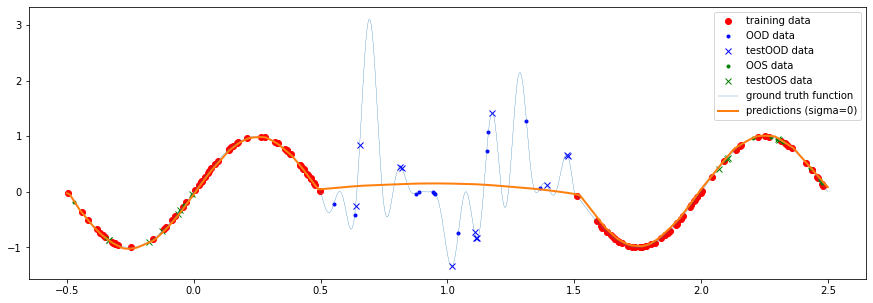

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.plot(x_test, model(x_test).detach(), linewidth=2., label='predictions (sigma=0)')
        
plt.legend()


In [13]:
deup_model = Model(n_hidden=256, hidden_layers=6, dropout_module=None)
deup_optimizer = torch.optim.Adam(deup_model.parameters(), lr=1e-4)

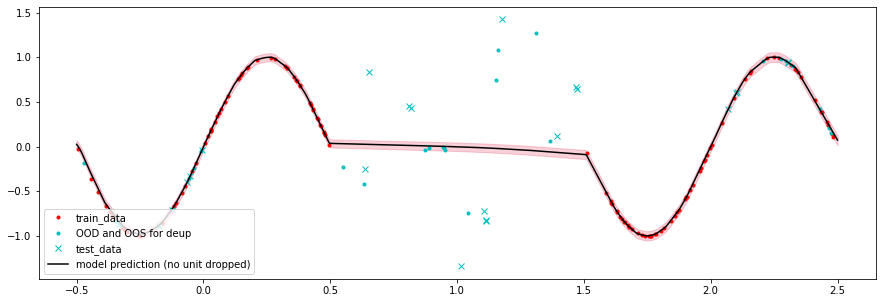

error on train data for deup: 0.034636731703786776
error on train data for deup excluding train: 0.2164502704350472
error on test data for deup: 0.40708151450523894


In [152]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup_model=deup_model)
print('error on train data for deup:', 
      eval_error_regular_deup(model, deup_model, full_X, full_Y).item())
print('error on train data for deup excluding train:', 
      eval_error_regular_deup(model, deup_model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))).item())
print('error on test data for deup:', 
      eval_error_regular_deup(model, deup_model, test_data[:][0], test_data[:][1]).item())

In [153]:
losses, _ = train_regular_deup(model, deup_model, deup_optimizer, full_data, epochs=1000, batch_size=32, callback=None)

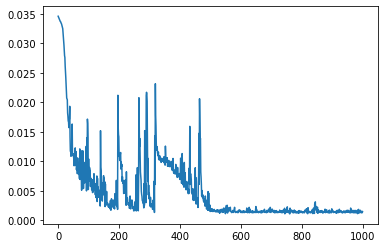

In [154]:
plt.plot(losses)

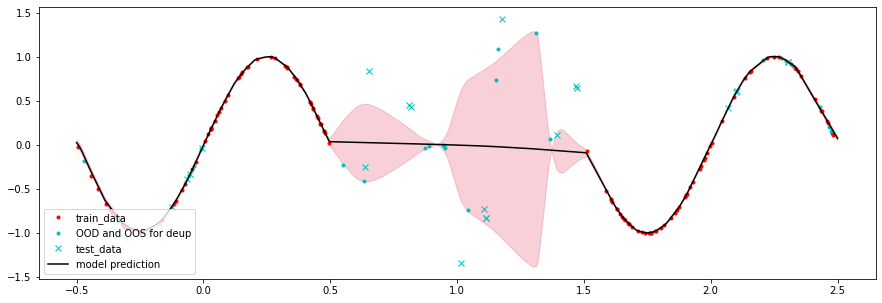

error on train data for deup: 0.0013067861010592127
error on train data for deup excluding train: 0.008167026277788546
error on test data for deup: 0.16247386072939415


In [350]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup_model=deup_model, save_plot='figs/deup_unc.png')
print('error on train data for deup:', 
      eval_error_regular_deup(model, deup_model, full_X, full_Y).item())
print('error on train data for deup excluding train:', 
      eval_error_regular_deup(model, deup_model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))).item())
print('error on test data for deup:', 
      eval_error_regular_deup(model, deup_model, test_data[:][0], test_data[:][1]).item())

In [146]:
deup_plusplus_model = Model(n_hidden=256, hidden_layers=6, dropout_module=None)
deup_plusplus_optimizer = torch.optim.Adam(deup_plusplus_model.parameters(), lr=1e-4)

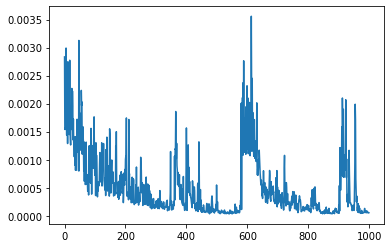

In [147]:
losses, _ = train_regular_deup_plusplus(model, deup_plusplus_model, deup_plusplus_optimizer,
                                        full_data, epochs=1000, batch_size=32, callback=None)
plt.plot(losses)

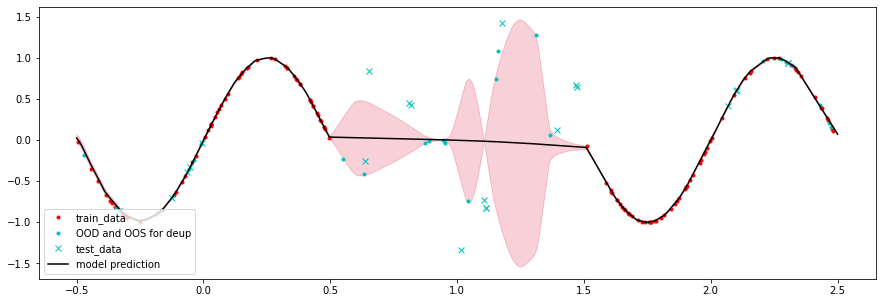

error on train data for deup: 0.0010293416309094259
error on train data for deup excluding train: 0.006433015678483557
error on test data for deup: 0.20914190430662458


In [349]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup_model=deup_plusplus_model)
print('error on train data for deup:', 
      eval_error_regular_deup(model, deup_plusplus_model, full_X, full_Y).item())
print('error on train data for deup excluding train:', 
      eval_error_regular_deup(model, deup_plusplus_model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))).item())
print('error on test data for deup:', 
      eval_error_regular_deup(model, deup_plusplus_model, test_data[:][0], test_data[:][1]).item())

## simulations of GPs

In [246]:
mean = model(x_test).detach().squeeze()
print(mean.shape)

torch.Size([1024])


In [247]:
cov = deup_model(x_test).detach().squeeze().diag().pow(2)
print(cov.shape)

torch.Size([1024, 1024])


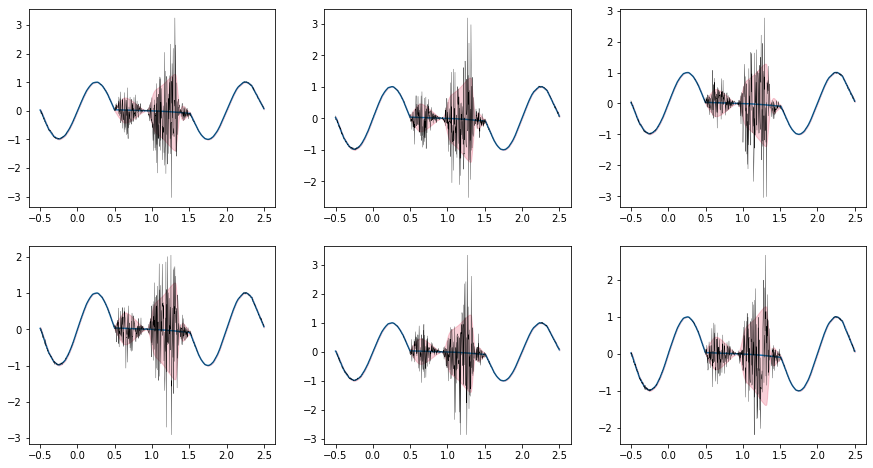

In [251]:
normal = torch.distributions.MultivariateNormal(mean, cov + 1e-9 * torch.eye(cov.shape[0]))
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for axs in axes:
    for ax in axs:
        ax.plot(x_test.squeeze(), normal.mean)
        ax.fill_between(x_test.squeeze(), normal.mean - normal.stddev, normal.mean + normal.stddev, color='crimson', alpha=.2)
        ax.plot(x_test.squeeze(), normal.sample(), color='k', linewidth=.3)
plt.show()

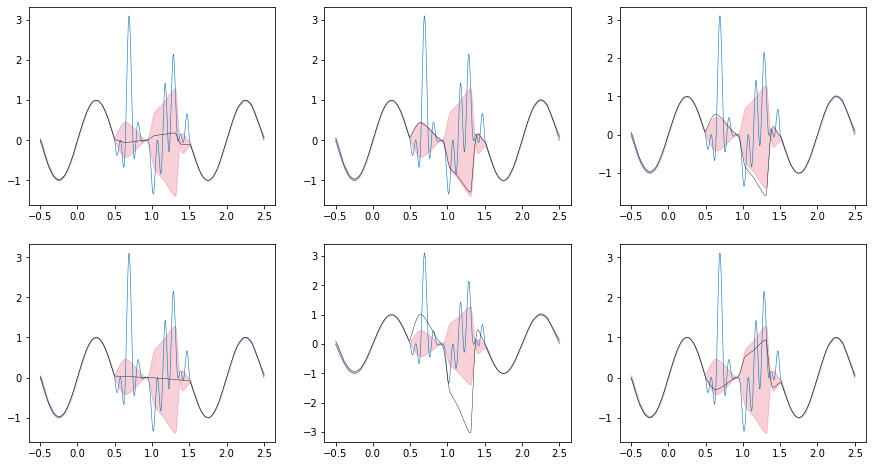

In [324]:
cov = torch.outer(deup_model(x_test).detach().squeeze(), deup_model(x_test).detach().squeeze())
normal = torch.distributions.MultivariateNormal(mean, cov + 1e-10 * torch.eye(cov.shape[0]))#cov + 1e-1)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for axs in axes:
    for ax in axs:
        ax.plot(x_test.squeeze(), y_test.squeeze(), label='ground truth', linewidth=.6)
        ax.fill_between(x_test.squeeze(), normal.mean - normal.stddev, normal.mean + normal.stddev, color='crimson', alpha=.2)
        ax.plot(x_test.squeeze(), normal.sample(), color='k', linewidth=.4)
plt.savefig('figs/linear_rank1.png')
plt.show()

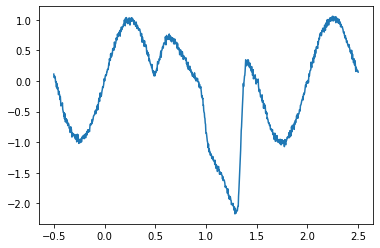

In [301]:
cov = torch.outer(deup_model(x_test).detach().squeeze(), deup_model(x_test).detach().squeeze())
normal = torch.distributions.MultivariateNormal(mean, cov + 1e-3 * torch.eye(cov.shape[0]))

plt.plot(x_test.squeeze(), normal.sample())

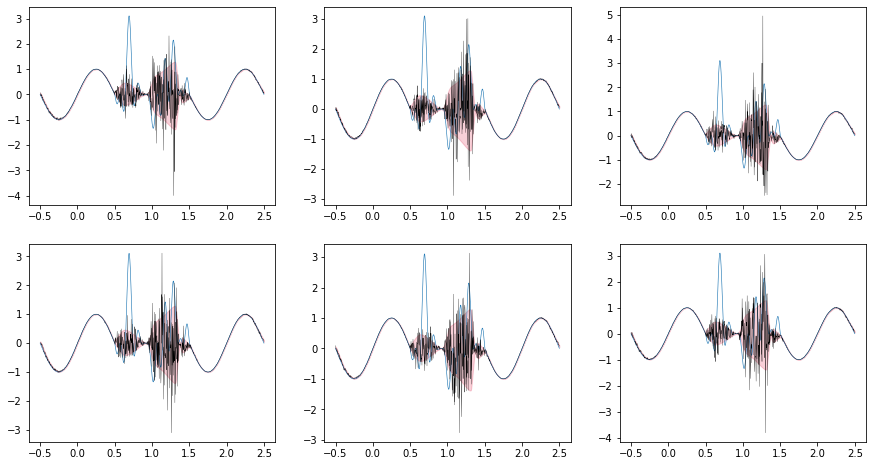

In [322]:
cov = deup_model(x_test).detach().squeeze().diag().pow(2)
normal = torch.distributions.MultivariateNormal(mean, cov + 1e-10 * torch.eye(cov.shape[0]))
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for axs in axes:
    for ax in axs:
        # ax.plot(x_test.squeeze(), normal.mean)
        ax.plot(x_test.squeeze(), y_test.squeeze(), label='ground truth', linewidth=.6)
        ax.fill_between(x_test.squeeze(), normal.mean - normal.stddev, normal.mean + normal.stddev, color='crimson', alpha=.2)
        ax.plot(x_test.squeeze(), normal.sample(), color='k', linewidth=.3)
plt.savefig('figs/whitenoise.png')
plt.show()

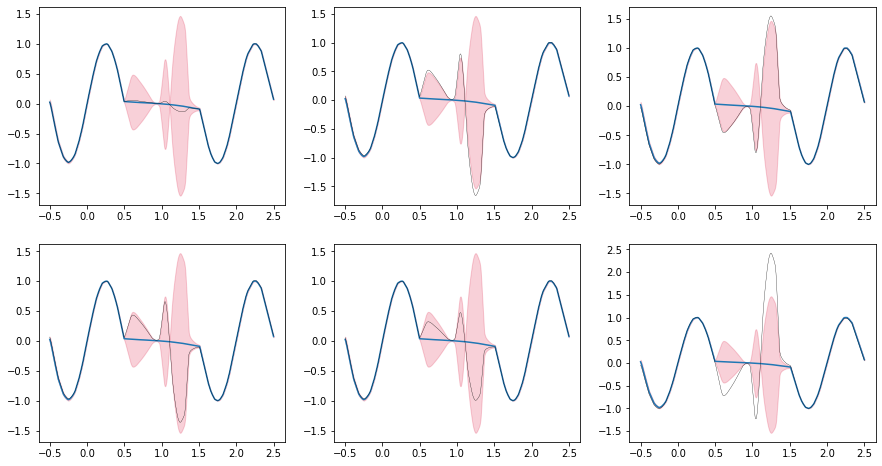

In [275]:
cov = torch.outer(deup_plusplus_model(x_test).detach().squeeze(), deup_plusplus_model(x_test).detach().squeeze())
normal = torch.distributions.MultivariateNormal(mean, cov + 1e-10 * torch.eye(cov.shape[0]))#cov + 1e-1)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for axs in axes:
    for ax in axs:
        ax.plot(x_test.squeeze(), normal.mean)
        ax.fill_between(x_test.squeeze(), normal.mean - normal.stddev, normal.mean + normal.stddev, color='crimson', alpha=.2)
        ax.plot(x_test.squeeze(), normal.sample(), color='k', linewidth=.3)
plt.show()

## higher ranks

In [371]:
deup_model5 = Model(n_hidden=256, hidden_layers=6, output_dim=32, dropout_module=None)
deup_optimizer5 = torch.optim.Adam(deup_model5.parameters(), lr=1e-4)

In [372]:
losses, _ = train_regular_deup(model, deup_model5, deup_optimizer5, full_data, epochs=1000, batch_size=32, callback=None)

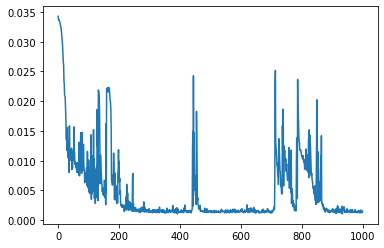

In [373]:
plt.plot(losses)

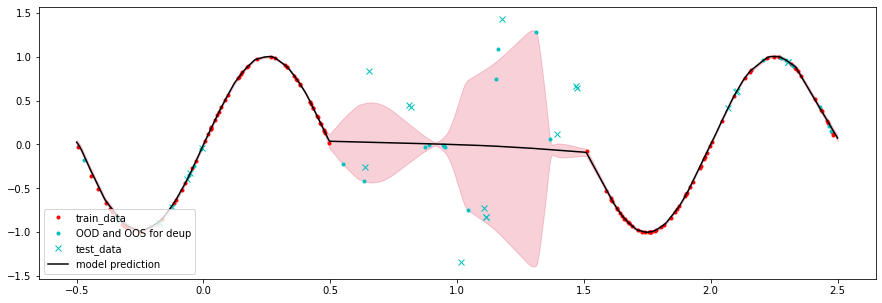

error on train data for deup: 0.001274238100829208
error on train data for deup excluding train: 0.007961729292150761
error on test data for deup: 0.17196253350414548


In [374]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup_model=deup_model5, save_plot=None)
print('error on train data for deup:', 
      eval_error_regular_deup(model, deup_model5, full_X, full_Y).item())
print('error on train data for deup excluding train:', 
      eval_error_regular_deup(model, deup_model5, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))).item())
print('error on test data for deup:', 
      eval_error_regular_deup(model, deup_model5, test_data[:][0], test_data[:][1]).item())

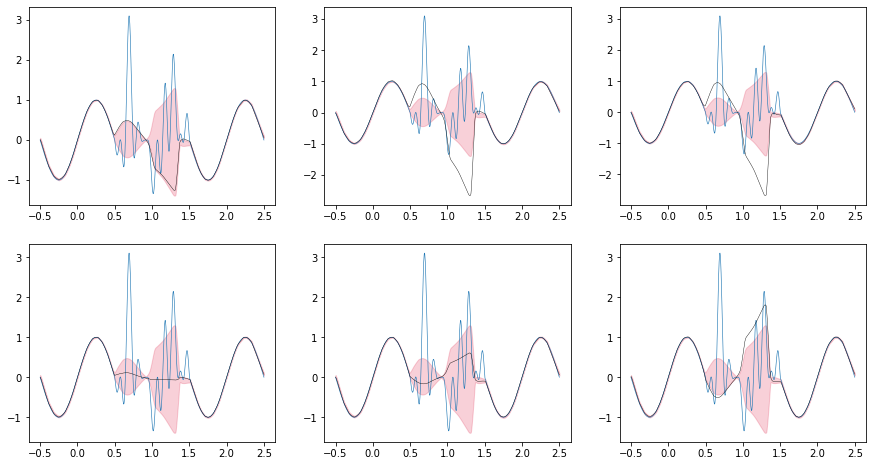

In [375]:
cov = torch.matmul(deup_model5(x_test).detach(), deup_model5(x_test).detach().T)
normal = torch.distributions.MultivariateNormal(mean, cov + 1e-10 * torch.eye(cov.shape[0]))#cov + 1e-1)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for axs in axes:
    for ax in axs:
        ax.plot(x_test.squeeze(), y_test.squeeze(), label='ground truth', linewidth=.6)
        ax.fill_between(x_test.squeeze(), normal.mean - normal.stddev, normal.mean + normal.stddev, color='crimson', alpha=.2)
        ax.plot(x_test.squeeze(), normal.sample(), color='k', linewidth=.4)
plt.savefig('figs/linear_rank5.png')
plt.show()

In [352]:
deup_model5(x_test).detach().shape

torch.Size([1024, 5])

In [354]:
cov = torch.matmul(deup_model5(x_test).detach(), deup_model5(x_test).detach().T)

In [358]:
(cov.diag() -deup_model5(x_test).detach().pow(2).sum(1)).mean()

tensor(5.4218e-19)

tensor([0.0005, 0.0005, 0.0005,  ..., 0.0002, 0.0002, 0.0002])